# Modelling the sample signal
As we had discussed previously, the GBIF data is of the type *presence-only* this means that we don't know for sure when a given species es really abscent or simply the has not been registered in that location. 
We may model this as:



In [13]:
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
from drivers.tree_builder import TreeNeo
from drivers.graph_models import TreeNode, Order, Family, graph,Kingdom,Occurrence
from drivers.graph_models import Cell,Mex4km, countObjectsOf
from drivers.graph_models import pickNode
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it
import numpy as np
import pymc3 as pm

## Use the ggplot style
plt.style.use('ggplot')

In [14]:
datatrain = pd.read_csv("/outputs/sample_fams_bats.csv")
datatrain = pd.read_csv("/outputs/training_dataset_complete_with_socioeconomical.csv")
## Read Predictors
datapred = pd.read_csv('/outputs/sample_predictors_complete.csv')
datacube_clean = datapred.dropna()

In [15]:
len(datapred.columns)

17

In [16]:
datatrain.columns

Index([u'Unnamed: 0', u'Y', u'DistanceToRoadMex_mean', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'WorldPopLatam2010_mean', u'Longitude', u'Latitude',
       u'vegid', u'vegname'],
      dtype='object')

In [17]:
from raster_api.tools import RasterData
from raster_api.models import raster_models_dic as models


In [18]:
vegname = datatrain[['vegid','vegname']]

In [19]:
gv = vegname.groupby('vegid')
gv.first()

,vegname
vegid,
1,Tropical and Subtropical Moist Broadleaf Forests
2,Tropical and Subtropical Dry Broadleaf Forests
3,Tropical and Subtropical Coniferous Forests
7,"Tropical and Subtropical Grasslands, Savannas ..."
12,"Mediterranean Forests, Woodlands and Scrub"
13,Deserts and Xeric Shrublands
14,Mangroves


In [20]:
## Convert to geopandas
## drop non real fields. this is important for the model
datatrain.drop(['vegname'],axis=1,inplace=True)

from external_plugins.spystats.spystats import tools as tl
datacube_clean = tl.toGeoDataFrame(datacube_clean,xcoord_name='Longitude',ycoord_name='Latitude')
datafull = datatrain.replace('N.A.',np.nan).astype('float')
Y = datafull.Y


In [21]:
datapred.columns

Index([u'Unnamed: 0', u'MaxTemperature', u'SolarRadiation', u'Elevation',
       u'MinTemperature', u'WorldPopLatam2010', u'WindSpeed',
       u'DistanceToRoadMex', u'MeanTemperature', u'Vapor', u'Precipitation',
       u'Longitude', u'Latitude', u'vegid', u'vegname', u'inegiv5id',
       u'inegiv5name'],
      dtype='object')

In [22]:
datatrain.columns

Index([u'Unnamed: 0', u'Y', u'DistanceToRoadMex_mean', u'Elevation_mean',
       u'MaxTemperature_mean', u'MeanTemperature_mean', u'MinTemperature_mean',
       u'Precipitation_mean', u'SolarRadiation_mean', u'Vapor_mean',
       u'WindSpeed_mean', u'WorldPopLatam2010_mean', u'Longitude', u'Latitude',
       u'vegid'],
      dtype='object')

In [23]:
## This is for calculating the signal

from pymc3.variational.callbacks import CheckParametersConvergence
with pm.Model() as model:

    ## [R | Y]
    tau = pm.HalfNormal('tau',sd=10)
    sigma = pm.HalfNormal('sigma',sd=10)
    phi = pm.Uniform('phi',0,15)
    
    Tau = pm.gp.cov.Constant(tau)
    cov = (sigma * pm.gp.cov.Matern32(2,phi,active_dims=[0,1])) + Tau

    ## Parameters for linear predictor
    #b0 = pm.Normal('b0',mu=0,sd=10)
    b = pm.Normal('b',mu=0,sd=10,shape=3)
    mf = pm.gp.mean.Linear(coeffs=[b]) 

    ## The latent function
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("latent_field", X=datafull[['Longitude','Latitude','DistanceToRoadMex_mean','WorldPopLatam2010_mean','vegid']].values,reparameterize=False)

    y_obs = pm.Bernoulli('y_obs',logit_p=f,observed=Y.values)
    
    %time mean_field = pm.fit(method='advi', callbacks=[CheckParametersConvergence()],n=15000)    
    %time trace = mean_field.sample(draws=5000)


    %time f_star = gp.conditional("f_star", datacube_clean[['Longitude','Latitude','DistanceToRoadMex','WorldPopLatam2010','vegid']].values)
  
    pred_samples = pm.sample_ppc(trace, vars=[f_star], samples=100)

   

Average Loss = 381.75: 100%|██████████| 15000/15000 [02:52<00:00, 86.89it/s]
Finished [100%]: Average Loss = 381.74
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 381.74


CPU times: user 11min 8s, sys: 14 s, total: 11min 22s
Wall time: 2min 56s
CPU times: user 1.74 s, sys: 12 ms, total: 1.76 s
Wall time: 1.3 s


  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 2.7 s, sys: 1.1 s, total: 3.81 s
Wall time: 1.52 s


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
100%|██████████| 100/100 [01:13<00:00,  1.37it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e64132090>,
      dtype=object)

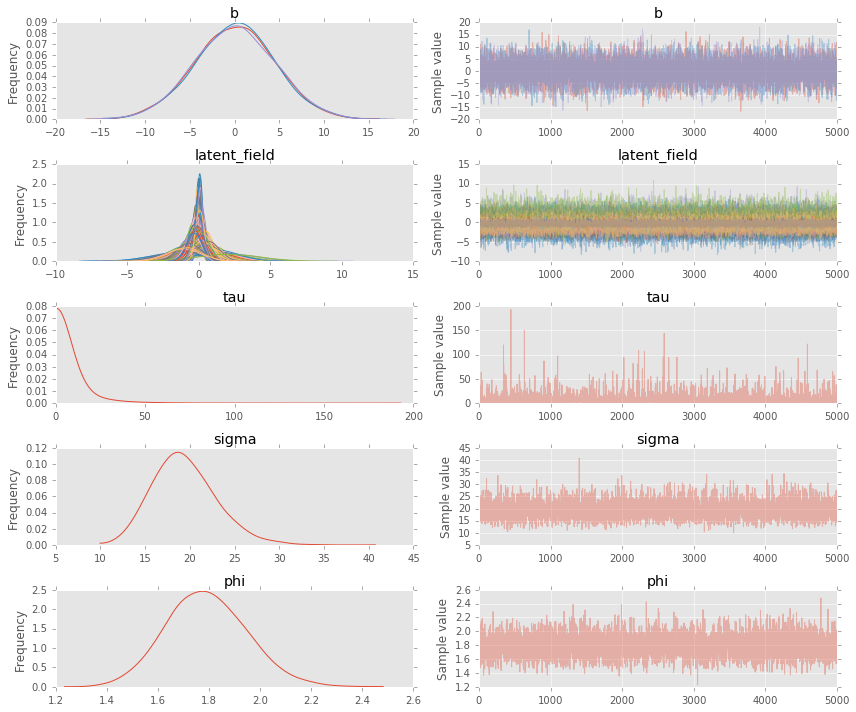

In [24]:

pm.traceplot(trace)

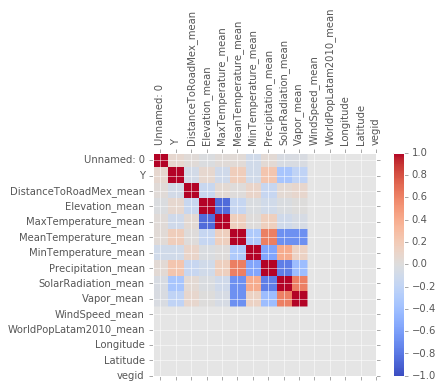

In [25]:
corr = datatrain.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(datatrain.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(datatrain.columns)
ax.set_yticklabels(datatrain.columns)
plt.show()

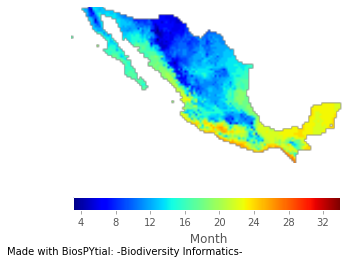

In [26]:
from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
elevation = RasterData(rastermodelinstance=MeanTemperature,border=Mexico.geom)
#Rescale to fit same number of pixels
pixel_size = 0.25
elevation.rescale(pixel_size)
elevation.display_field(origin='Lower')

preds = pd.DataFrame(pred_samples['f_star']).transpose()




In [27]:
with model:
    mapp = pm.find_MAP()

logp = 17,400, ||grad|| = 1,036.4: 100%|██████████| 70/70 [04:44<00:00,  4.07s/it]    


In [29]:
lat_field = mapp['f_star']

In [30]:
lat_field.shape

(2645,)

In [43]:
preds.shape

(2645, 100)

In [102]:
## Calculate some summary statistics
import scipy.special as sp
alpha = sp.logit(0.5) 
mean_sample = preds.mean(axis=1)
q_025 = preds.quantile(0.025,axis=1)
q_975 = preds.quantile(0.975,axis=1)
prob_gt05 = preds.apply(lambda row : float(sum(row > alpha))/100,axis=1)
surface_data = pd.DataFrame({'mean_sample' : mean_sample, 'q_025':q_025,'q_975':q_975,'prob_gt05':prob_gt05,'map':lat_field})

In [103]:
surface_data['idx'] = datacube_clean.index.values
predictions = datapred.merge(surface_data,how='left',left_index=True,right_on='idx',suffixes=('_obs','_pred'))
predicted_data = predictions.mean_sample.values
mean = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
ql_presences_of_something = RasterContainer(predictions.mean_sample.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")


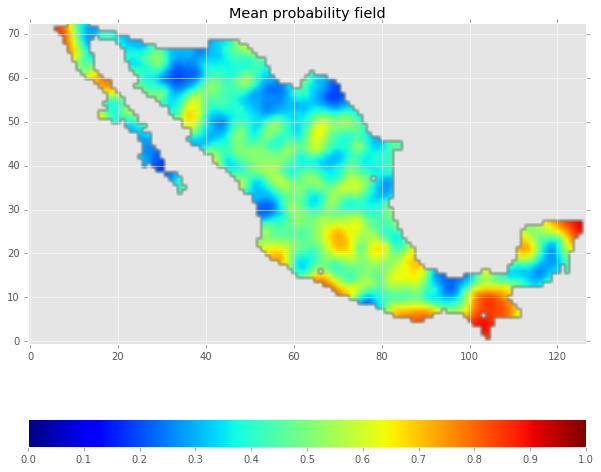

In [104]:
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_presences_of_something.rasterdata.bands[1].data(),origin='Lower',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("Mean probability field")
plt.colorbar(orientation='horizontal')

In [105]:
## With pcolor
M = ql_presences_of_something.rasterdata.bands[1].data()
minx = predictions.Latitude.min()
maxx = predictions.Latitude.max()
miny = predictions.Longitude.min()
maxy = predictions.Longitude.max()
i,j = M.shape
#np.meshgrid

In [106]:
#X = np.linspace(minx,maxx,j)
#Y = np.linspace(miny,maxy,i)
#XX,YY = np.meshgrid(X,Y)

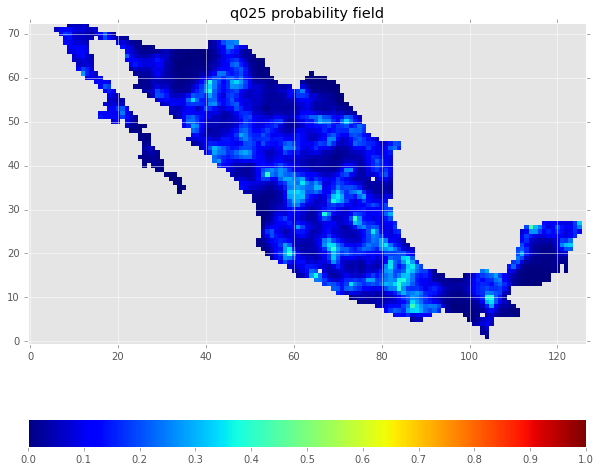

In [107]:
ql_025 = RasterContainer(predictions.q_025.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_025.rasterdata.bands[1].data(),origin='Lower',interpolation='None',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("q025 probability field")

plt.colorbar(orientation='horizontal')

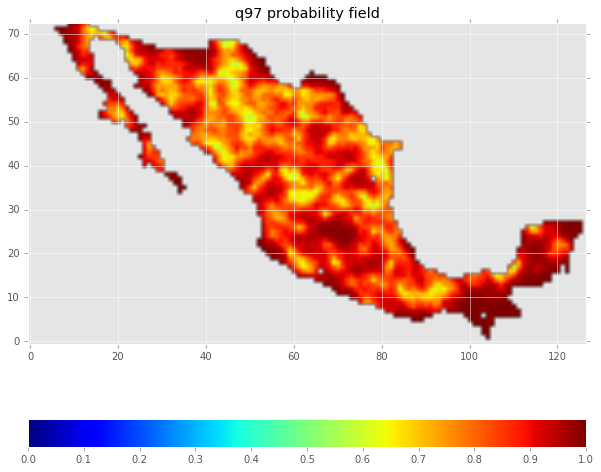

In [108]:
ql_97 = RasterContainer(predictions.q_975.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(ql_97.rasterdata.bands[1].data(),origin='Lower',vmin=0.0,vmax=1.0)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("q97 probability field")
plt.colorbar(orientation='horizontal')

## Exceeding probability


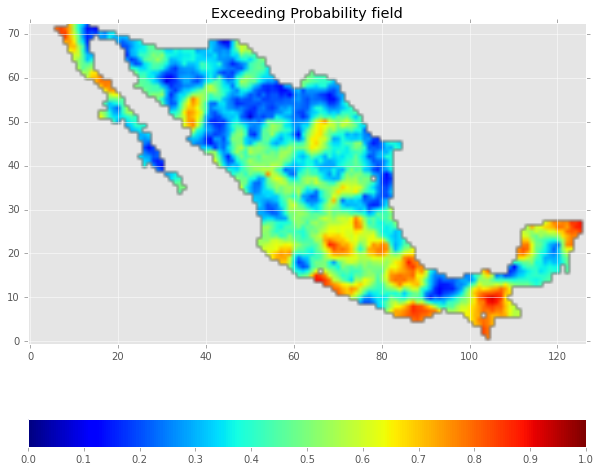

In [131]:
## Probability of the probaaility of presences bigger than 0.5
prob5 = RasterContainer(predictions.prob_gt05.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")
#prob5.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)

fig, ax = plt.subplots(figsize=(10, 9));
plt.imshow(prob5.rasterdata.bands[0].data(),origin='Lower',vmin=0.0,vmax=1.0)#,cmap=plt.cm.RdBu)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("Exceeding Probability field")
plt.colorbar(orientation='horizontal')


In [110]:
## Plot the MAP 
pmap = RasterContainer(predictions.map.values,use_metadata_from=elevation.rasterdata,exponential_fam="Bernoulli")


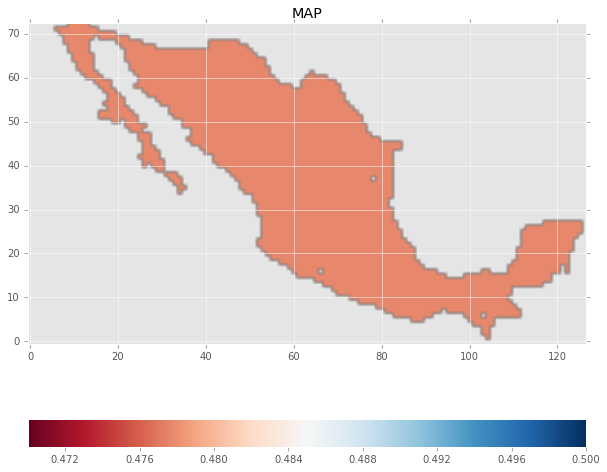

In [130]:
fig, ax = plt.subplots(figsize=(10, 9));

plt.imshow(pmap.rasterdata.bands[1].data(),origin='Lower',vmin=0.47,vmax=0.5,cmap=plt.cm.RdBu)
#ql_presences_of_something.display_field(band=2,origin='Lower',cmap=plt.cm.RdBu)
plt.title("MAP")
plt.colorbar(orientation='horizontal')


In [129]:
np.ptp(sp.expit(lat_field)) 

2.8745205882252378e-08

In [108]:
ql_025.exportToGeoTiff("q025_signal")
ql_97.exportToGeoTiff("q97_signal")

In [53]:
## Visualizing distance to road map
#from raster_api.tools import RasterContainer
from raster_api.models import ETOPO1,MeanTemperature,DistanceToRoadMex
from raster_api.tools import RasterData
from sketches.models import Country
from mesh.models import MexMesh
Mexico = Country.objects.filter(name__contains="exico").get()
mexican_cells = MexMesh.objects.filter(cell__intersects=Mexico.geom)
distroad = RasterData(rastermodelinstance=DistanceToRoadMex,border=Mexico.geom)
#distroad.display_field()

In [54]:
distroad.getRaster()

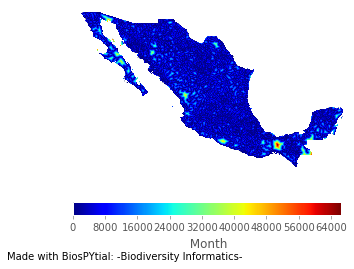

In [56]:
distroad.display_field()

In [105]:
#ql_presences_of_something.exportToGeoTiff("mean_signal")